# Recommender Systems 2020/21

### Practice 2 - Non personalized recommenders

### We will use the Movielens 10 million dataset. We download it and uncompress the file we need.

### In order to reuse it in the future, we will put all of that in a class that we can call easily

In [1]:
from urllib.request import urlretrieve
import zipfile

In [2]:
import os

# If file exists, skip the download
data_file_path = "data/Movielens_10M/"
data_file_name = data_file_path + "movielens_10m.zip"

# If directory does not exist, create
if not os.path.exists(data_file_path):
    os.makedirs(data_file_path)

if not os.path.exists(data_file_name):
    urlretrieve ("http://files.grouplens.org/datasets/movielens/ml-10m.zip", data_file_name)

In [3]:
dataFile = zipfile.ZipFile("data/Movielens_10M/movielens_10m.zip")

URM_path = dataFile.extract("ml-10M100K/ratings.dat", path = "data/Movielens_10M")

URM_file = open(URM_path, 'r')

In [4]:
type(URM_file)

_io.TextIOWrapper

#### Let's take a look at the data

In [5]:
import pandas as pd

In [6]:
URM_all_dataframe = pd.read_csv(filepath_or_buffer=URM_path, 
                                sep="::", 
                                header=None, 
                                dtype={0:int, 1:int, 2:float, 3:int})

URM_all_dataframe.columns = ["UserID", "ItemID", "Interaction", "Timestamp"]

C:\Users\ferra\Anaconda3\envs\RecSysFramework\lib\site-packages\ipykernel_launcher.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  after removing the cwd from sys.path.


In [7]:
URM_all_dataframe.head(n=10)

,UserID,ItemID,Interaction,Timestamp
0,1,122,5.0,838985046
1,1,185,5.0,838983525
2,1,231,5.0,838983392
3,1,292,5.0,838983421
4,1,316,5.0,838983392
5,1,329,5.0,838983392
6,1,355,5.0,838984474
7,1,356,5.0,838983653
8,1,362,5.0,838984885
9,1,364,5.0,838983707


In [8]:
print ("The number of interactions is {}".format(len(URM_all_dataframe)))

The number of interactions is 10000054


### We can use this data to create a sparse matrix, notice that we have red UserID and ItemID as int
### This is not always possible if the IDs are alphanumeric

### Now we can extract the list of unique user id and item id and display some statistics

In [9]:
userID_unique = URM_all_dataframe["UserID"].unique()
itemID_unique = URM_all_dataframe["ItemID"].unique()

In [10]:
n_users = len(userID_unique)
n_items = len(itemID_unique)
n_interactions = len(URM_all_dataframe)

print ("Number of items\t {}, Number of users\t {}".format(n_items, n_users))
print ("Max ID items\t {}, Max Id users\t {}\n".format(max(itemID_unique), max(userID_unique)))

Number of items	 10677, Number of users	 69878
Max ID items	 65133, Max Id users	 71567



### See that the max ID of items and users is higher than the number of unique values -> empty profiles
### We should remove empty indices, to do so we create a new mapping

In [11]:
user_original_ID_to_index_dict = {}

for user_id in userID_unique:
    user_original_ID_to_index_dict[user_id] = len(user_original_ID_to_index_dict)

In [12]:
item_original_ID_to_index_dict = {}

for item_id in itemID_unique:
    item_original_ID_to_index_dict[item_id] = len(item_original_ID_to_index_dict)

In [13]:
original_item_ID = 292
print("New index for item {} is {}".format(original_item_ID, item_original_ID_to_index_dict[original_item_ID]))

New index for item 292 is 3


### We now replace the IDs in the dataframe and we are ready to use the data

In [14]:
URM_all_dataframe["UserID"] = [user_original_ID_to_index_dict[user_original] for user_original in
                                      URM_all_dataframe["UserID"].values]

URM_all_dataframe["ItemID"] = [item_original_ID_to_index_dict[item_original] for item_original in 
                                      URM_all_dataframe["ItemID"].values]

In [15]:
URM_all_dataframe.head(n=10)

,UserID,ItemID,Interaction,Timestamp
0,0,0,5.0,838985046
1,0,1,5.0,838983525
2,0,2,5.0,838983392
3,0,3,5.0,838983421
4,0,4,5.0,838983392
5,0,5,5.0,838983392
6,0,6,5.0,838984474
7,0,7,5.0,838983653
8,0,8,5.0,838984885
9,0,9,5.0,838983707


In [16]:
userID_unique = URM_all_dataframe["UserID"].unique()
itemID_unique = URM_all_dataframe["ItemID"].unique()

n_users = len(userID_unique)
n_items = len(itemID_unique)
n_interactions = len(URM_all_dataframe)

print ("Number of items\t {}, Number of users\t {}".format(n_items, n_users))
print ("Max ID items\t {}, Max Id users\t {}\n".format(max(itemID_unique), max(userID_unique)))
print ("Average interactions per user {:.2f}".format(n_interactions/n_users))
print ("Average interactions per item {:.2f}\n".format(n_interactions/n_items))

print ("Sparsity {:.2f} %".format((1-float(n_interactions)/(n_items*n_users))*100))


Number of items	 10677, Number of users	 69878
Max ID items	 10676, Max Id users	 69877

Average interactions per user 143.11
Average interactions per item 936.60

Sparsity 98.66 %


##### Rating distribution in time

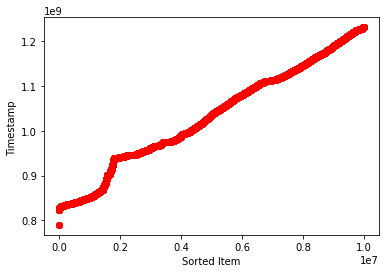

In [17]:
import matplotlib.pyplot as pyplot

# Clone the list to avoid changing the ordering of the original data
timestamp_sorted = list(URM_all_dataframe["Timestamp"].values)
timestamp_sorted.sort()


pyplot.plot(timestamp_sorted, 'ro')
pyplot.ylabel('Timestamp ')
pyplot.xlabel('Sorted Item')
pyplot.show()

#### To store the data we use a sparse matrix. We build it as a COO matrix and then change its format

#### The COO constructor expects (data, (row, column))

In [18]:
import scipy.sparse as sps

URM_all = sps.coo_matrix((URM_all_dataframe["Interaction"].values, 
                          (URM_all_dataframe["UserID"].values, URM_all_dataframe["ItemID"].values)))

URM_all

<69878x10677 sparse matrix of type '<class 'numpy.float64'>'
	with 10000054 stored elements in COOrdinate format>

In [19]:
URM_all.tocsr()

<69878x10677 sparse matrix of type '<class 'numpy.float64'>'
	with 10000054 stored elements in Compressed Sparse Row format>

### We compute the item popularity as the number of interaction in each column

### We can use the properties of sparse matrices in CSC format

In [20]:
import numpy as np

item_popularity = np.ediff1d(URM_all.tocsc().indptr)
item_popularity

array([ 2412, 14975, 17851, ...,     1,     1,     1], dtype=int32)

In [21]:
item_popularity = np.sort(item_popularity)
item_popularity

array([    1,     1,     1, ..., 33668, 34457, 34864], dtype=int32)

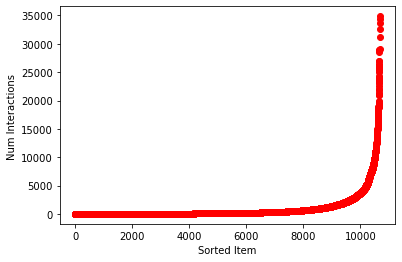

In [22]:
pyplot.plot(item_popularity, 'ro')
pyplot.ylabel('Num Interactions ')
pyplot.xlabel('Sorted Item')
pyplot.show()

In [23]:
ten_percent = int(n_items/10)

print("Average per-item interactions over the whole dataset {:.2f}".
      format(item_popularity.mean()))

print("Average per-item interactions for the top 10% popular items {:.2f}".
      format(item_popularity[-ten_percent:].mean()))

print("Average per-item interactions for the least 10% popular items {:.2f}".
      format(item_popularity[:ten_percent].mean()))

print("Average per-item interactions for the median 10% popular items {:.2f}".
      format(item_popularity[int(n_items*0.45):int(n_items*0.55)].mean()))

Average per-item interactions over the whole dataset 936.60
Average per-item interactions for the top 10% popular items 6479.52
Average per-item interactions for the least 10% popular items 5.23
Average per-item interactions for the median 10% popular items 136.45


In [24]:
print("Number of items with zero interactions {}".
      format(np.sum(item_popularity==0)))

Number of items with zero interactions 0


### We compute the user activity (profile length) as the number of interaction in each row

### We can use the properties of sparse matrices in CSR format

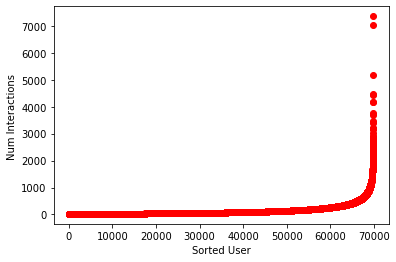

In [25]:
user_activity = np.ediff1d(URM_all.tocsr().indptr)
user_activity = np.sort(user_activity)


pyplot.plot(user_activity, 'ro')
pyplot.ylabel('Num Interactions ')
pyplot.xlabel('Sorted User')
pyplot.show()

### In order to evaluate our recommender we have to define:
* A splitting of the data in URM_train and URM_test
* An evaluation metric
* A functon computing the evaluation for each user

### The splitting of the data is very important to ensure your algorithm is evaluated in a realistic scenario by using test it has never seen. We create two splits:
#### - Train data: we will use this to train our model
#### - Test data: we will use this to evaluate our model

In [26]:
train_test_split = 0.80

n_interactions = URM_all.nnz


train_mask = np.random.choice([True,False], n_interactions, p=[train_test_split, 1-train_test_split])
train_mask

array([ True,  True,  True, ...,  True,  True,  True])

In [27]:
URM_train = sps.csr_matrix((URM_all.data[train_mask],
                            (URM_all.row[train_mask], URM_all.col[train_mask])))

URM_train

<69878x10677 sparse matrix of type '<class 'numpy.float64'>'
	with 7999092 stored elements in Compressed Sparse Row format>

In [28]:
test_mask = np.logical_not(train_mask)

URM_test = sps.csr_matrix((URM_all.data[test_mask],
                            (URM_all.row[test_mask], URM_all.col[test_mask])))

URM_test

<69878x10669 sparse matrix of type '<class 'numpy.float64'>'
	with 2000962 stored elements in Compressed Sparse Row format>

### Evaluation metric

#### We call items in the test set 'relevant'

In [29]:
user_id = 124
relevant_items = URM_test[user_id].indices
relevant_items

array([  22,   24,   38,   75,  137,  170,  175,  181,  228,  238,  373,
        394,  406,  418, 1077, 1283, 1318, 1496])

#### Say that we have a recommendation list such as this

In [30]:
recommended_items = np.array([241, 1622, 15, 857, 5823])
recommended_items

array([ 241, 1622,   15,  857, 5823])

In [31]:
is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
is_relevant

array([False, False, False, False, False])

### Precision: how many of the recommended items are relevant

In [32]:
def precision(recommended_items, relevant_items):
    
    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
    
    precision_score = np.sum(is_relevant, dtype=np.float32) / len(is_relevant)
    
    return precision_score

### Recall: how many of the relevant items I was able to recommend

In [33]:
def recall(recommended_items, relevant_items):
    
    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
    
    recall_score = np.sum(is_relevant, dtype=np.float32) / relevant_items.shape[0]
    
    return recall_score

### Mean Average Precision

In [34]:
def MAP(recommended_items, relevant_items):
   
    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
    
    # Cumulative sum: precision at 1, at 2, at 3 ...
    p_at_k = is_relevant * np.cumsum(is_relevant, dtype=np.float32) / (1 + np.arange(is_relevant.shape[0]))
    
    map_score = np.sum(p_at_k) / np.min([relevant_items.shape[0], is_relevant.shape[0]])

    return map_score

### Now that we have the data, we can build our first recommender. We need two things:
* a 'fit' function to train our model
* a 'recommend' function that uses our model to recommend

### Let's start with a random recommender

#### In a random recommend we don't have anything to learn from the data

In [35]:
class RandomRecommender(object):

    def fit(self, URM_train):
           
        self.n_items = URM_train.shape[1]
    
    
    def recommend(self, user_id, at=5):
    
        recommended_items = np.random.choice(self.n_items, at)

        return recommended_items

In [36]:
randomRecommender = RandomRecommender()
randomRecommender.fit(URM_train)

for user_id in range(10):
    print(randomRecommender.recommend(user_id, at=5))

[7986 3801 7338 2923 9124]
[ 5218 10421  7432  2762  2155]
[ 6380  4376  8399  7341 10076]
[3477 8786 3880 9180   94]
[ 1271  1832   471 10085 10276]
[3703 4564 6829 5507 3698]
[7149 1980 3795 7475 1637]
[9023 9658  976 6547 7774]
[2663 4822 7007 9476 7527]
[ 6599  6326  3601  9543 10289]


### Put all together in an evaluation function and let's test it!

In [37]:
# We pass as paramether the recommender class

def evaluate_algorithm(URM_test, recommender_object, at=5):
    
    cumulative_precision = 0.0
    cumulative_recall = 0.0
    cumulative_MAP = 0.0
    
    num_eval = 0


    for user_id in range(URM_test.shape[0]):

        relevant_items = URM_test.indices[URM_test.indptr[user_id]:URM_test.indptr[user_id+1]]
        
        if len(relevant_items)>0:
            
            recommended_items = recommender_object.recommend(user_id, at=at)
            num_eval+=1

            cumulative_precision += precision(recommended_items, relevant_items)
            cumulative_recall += recall(recommended_items, relevant_items)
            cumulative_MAP += MAP(recommended_items, relevant_items)
            
    cumulative_precision /= num_eval
    cumulative_recall /= num_eval
    cumulative_MAP /= num_eval
    
    print("Recommender performance is: Precision = {:.4f}, Recall = {:.4f}, MAP = {:.4f}".format(
        cumulative_precision, cumulative_recall, cumulative_MAP)) 


In [38]:
evaluate_algorithm(URM_test, randomRecommender)

Recommender performance is: Precision = 0.0029, Recall = 0.0005, MAP = 0.0014


### So the code works. The performance however...

# Top Popular recommender

#### We recommend to all users the most popular items, that is those with the highest number of interactions
#### In this case our model is the item popularity

In [39]:
class TopPopRecommender(object):

    def fit(self, URM_train):

        item_popularity = np.ediff1d(URM_all.tocsc().indptr)

        # We are not interested in sorting the popularity value,
        # but to order the items according to it
        self.popular_items = np.argsort(item_popularity)
        self.popular_items = np.flip(self.popular_items, axis = 0)
    
    
    def recommend(self, user_id, at=5):
    
        recommended_items = self.popular_items[0:at]

        return recommended_items



### Now train and test our model

In [40]:
topPopRecommender = TopPopRecommender()
topPopRecommender.fit(URM_train)

In [41]:
for user_id in range(10):
    print(topPopRecommender.recommend(user_id, at=5))

[1008    7  139   14 1293]
[1008    7  139   14 1293]
[1008    7  139   14 1293]
[1008    7  139   14 1293]
[1008    7  139   14 1293]
[1008    7  139   14 1293]
[1008    7  139   14 1293]
[1008    7  139   14 1293]
[1008    7  139   14 1293]
[1008    7  139   14 1293]


In [42]:
evaluate_algorithm(URM_test, topPopRecommender, at=5)

Recommender performance is: Precision = 0.0954, Recall = 0.0307, MAP = 0.0526


### That's better, but we can improve

### Hint, remove items already seen by the user. We can either remove them from the recommended item list or we can set them to a score so low that it will cause them to end at the very bottom of all the available items

In [43]:
class TopPopRecommender(object):

    def fit(self, URM_train):
        
        self.URM_train = URM_train

        item_popularity = np.ediff1d(URM_all.tocsc().indptr)

        # We are not interested in sorting the popularity value,
        # but to order the items according to it
        self.popular_items = np.argsort(item_popularity)
        self.popular_items = np.flip(self.popular_items, axis = 0)
    
    
    def recommend(self, user_id, at=5, remove_seen=True):

        if remove_seen:
            seen_items = self.URM_train.indices[self.URM_train.indptr[user_id]:self.URM_train.indptr[user_id+1]]
            
            unseen_items_mask = np.in1d(self.popular_items, seen_items,
                                        assume_unique=True, invert = True)

            unseen_items = self.popular_items[unseen_items_mask]

            recommended_items = unseen_items[0:at]

        else:
            recommended_items = self.popular_items[0:at]
            

        return recommended_items


In [44]:
topPopRecommender_removeSeen = TopPopRecommender()
topPopRecommender_removeSeen.fit(URM_train)

for user_id in range(10):
    print(topPopRecommender_removeSeen.recommend(user_id, at=5))

[1008  139 1293   22  175]
[1008    7  139   14 1293]
[1008    7  139   14 1293]
[1008    7  139   14 1293]
[1008    7   14 1293   22]
[1008    7  139   14 1293]
[1008    7   14 1293   22]
[1008    7  139   14 1293]
[1008    7  139   14 1293]
[  14 1293   22   19   24]


In [45]:
evaluate_algorithm(URM_test, topPopRecommender_removeSeen)

Recommender performance is: Precision = 0.1977, Recall = 0.0530, MAP = 0.1468


#### Simple but effective. Always remove seen items if your purpose is to recommend "new" ones

# Global effects recommender

#### We recommend to all users the highest rated items

#### First we compute the average of all ratings, or global average

In [46]:
globalAverage = np.mean(URM_train.data)

print("The global average is {:.2f}".format(globalAverage))

The global average is 3.51


#### We subtract the bias to all ratings

In [47]:
URM_train_unbiased = URM_train.copy()

URM_train_unbiased.data -= globalAverage

print(URM_train_unbiased.data[0:10])

[1.48788181 1.48788181 1.48788181 1.48788181 1.48788181 1.48788181
 1.48788181 1.48788181 1.48788181 1.48788181]


#### Then we compute the average rating for each item, or itemBias

In [48]:
item_mean_rating = URM_train_unbiased.mean(axis=0)
item_mean_rating

matrix([[-1.74643806e-02, -6.55957996e-02, -1.18630771e-01, ...,
         -2.16394028e-05,  6.98190864e-06,  6.98190864e-06]])

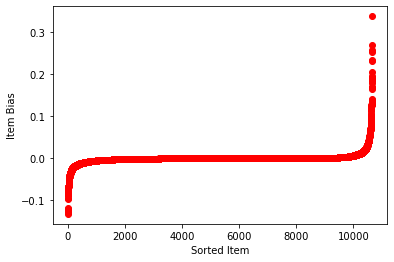

In [49]:
item_mean_rating = np.array(item_mean_rating).squeeze()
item_mean_rating = np.sort(item_mean_rating[item_mean_rating!=0])

pyplot.plot(item_mean_rating, 'ro')
pyplot.ylabel('Item Bias')
pyplot.xlabel('Sorted Item')
pyplot.show()

#### And the average rating for each user, or userBias

In [50]:
user_mean_rating = URM_train_unbiased.mean(axis=1)
user_mean_rating

matrix([[ 0.00209031],
        [-0.00044076],
        [ 0.00077   ],
        ...,
        [ 0.00333601],
        [ 0.0013138 ],
        [-0.00117385]])

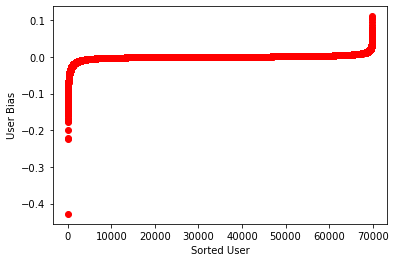

In [51]:
user_mean_rating = np.array(user_mean_rating).squeeze()
user_mean_rating = np.sort(user_mean_rating[user_mean_rating!=0.0])

pyplot.plot(user_mean_rating, 'ro')
pyplot.ylabel('User Bias')
pyplot.xlabel('Sorted User')
pyplot.show()

#### Now we can sort the items by their itemBias and use the same recommendation principle as in TopPop

In [52]:
class GlobalEffectsRecommender(object):

    def fit(self, URM_train):
        
        self.URM_train = URM_train

        globalAverage = np.mean(URM_train.data)

        URM_train_unbiased = URM_train.copy()
        URM_train_unbiased.data -= globalAverage

        item_mean_rating = URM_train_unbiased.mean(axis=0)
        item_mean_rating = np.array(item_mean_rating).squeeze()

        self.bestRatedItems = np.argsort(item_mean_rating)
        self.bestRatedItems = np.flip(self.bestRatedItems, axis = 0)

        
    
    def recommend(self, user_id, at=5, remove_seen=True):

        if remove_seen:
            seen_items = self.URM_train.indices[self.URM_train.indptr[user_id]:self.URM_train.indptr[user_id+1]]
            
            unseen_items_mask = np.in1d(self.bestRatedItems, seen_items,
                                        assume_unique=True, invert = True)

            unseen_items = self.bestRatedItems[unseen_items_mask]

            recommended_items = unseen_items[0:at]

        else:
            recommended_items = self.bestRatedItems[0:at]
            

        return recommended_items



In [53]:
globalEffectsRecommender = GlobalEffectsRecommender()
globalEffectsRecommender.fit(URM_train)

evaluate_algorithm(URM_test, globalEffectsRecommender)

Recommender performance is: Precision = 0.1691, Recall = 0.0389, MAP = 0.1226


### Now let's try to combine User bias an item bias

In [54]:
class GlobalEffectsRecommender(object):

    def fit(self, URM_train):
        
        self.URM_train = URM_train

        globalAverage = np.mean(URM_train.data)

        URM_train_unbiased = URM_train.copy()
        URM_train_unbiased.data -= globalAverage
        
        # User Bias
        user_mean_rating = URM_train_unbiased.mean(axis=1)
        user_mean_rating = np.array(user_mean_rating).squeeze()
        
        # In order to apply the user bias we have to change the rating value 
        # in the URM_train_unbiased inner data structures
        # If we were to write:
        # URM_train_unbiased[user_id].data -= user_mean_rating[user_id]
        # we would change the value of a new matrix with no effect on the original data structure
        for user_id in range(len(user_mean_rating)):
            start_position = URM_train_unbiased.indptr[user_id]
            end_position = URM_train_unbiased.indptr[user_id+1]
            
            URM_train_unbiased.data[start_position:end_position] -= user_mean_rating[user_id]

        # Item Bias
        item_mean_rating = URM_train_unbiased.mean(axis=0)
        item_mean_rating = np.array(item_mean_rating).squeeze()

        self.bestRatedItems = np.argsort(item_mean_rating)
        self.bestRatedItems = np.flip(self.bestRatedItems, axis = 0)

        
    
    def recommend(self, user_id, at=5, remove_seen=True):

        if remove_seen:

            seen_items = self.URM_train.indices[self.URM_train.indptr[user_id]:self.URM_train.indptr[user_id+1]]
            
            unseen_items_mask = np.in1d(self.bestRatedItems, seen_items,
                                        assume_unique=True, invert = True)

            unseen_items = self.bestRatedItems[unseen_items_mask]

            recommended_items = unseen_items[0:at]


        else:
            recommended_items = self.bestRatedItems[0:at]
            

        return recommended_items


In [55]:
globalEffectsRecommender = GlobalEffectsRecommender()
globalEffectsRecommender.fit(URM_train)

evaluate_algorithm(URM_test, globalEffectsRecommender)

Recommender performance is: Precision = 0.1691, Recall = 0.0389, MAP = 0.1226


#### The result is identical. User bias is essential in case of rating prediction but not relevant in case of TopK recommendations.

## Question:

#### Why is GlobalEffect performing worse than TopPop even if we are taking into account more information about the interaction?
.

.

.

.

.

.

.

.

.

### The test data contains a lot of low rating interactions... We are testing against those as well, but GlobalEffects is penalizing interactions with low rating

In [56]:
URM_test.data[URM_test.data<=2]

array([2., 1., 2., ..., 2., 1., 1.])

### In reality we want to recommend items rated in a positive way, so let's build a new Test set with positive interactions only

In [57]:
URM_test_positiveOnly = URM_test.copy()

URM_test_positiveOnly.data[URM_test.data<=2] = 0
URM_test_positiveOnly.eliminate_zeros()
URM_test_positiveOnly

<69878x10669 sparse matrix of type '<class 'numpy.float64'>'
	with 1723597 stored elements in Compressed Sparse Row format>

In [58]:
print("Deleted {} negative interactions".format(URM_test.nnz - URM_test_positiveOnly.nnz))

Deleted 277365 negative interactions


#### Run the evaluation again for both

In [59]:
evaluate_algorithm(URM_test_positiveOnly, topPopRecommender_removeSeen)

Recommender performance is: Precision = 0.1877, Recall = 0.0565, MAP = 0.1383


In [60]:
evaluate_algorithm(URM_test_positiveOnly, globalEffectsRecommender)

Recommender performance is: Precision = 0.1632, Recall = 0.0421, MAP = 0.1183


### GlobalEffects performs worse again...

### Ideas?

.

.

.

.

.

.

.

.

.

### Sometimes ratings are not really more informative than interactions, depends on their quality

#### Take-home message: how you build your splitting and the task you are building the algorithm for are tightly interlinked